###  Chemiscope Auto

In [206]:
from mace.calculators import mace_off, mace_mp
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
import chemiscope

Load QM9

In [207]:
from load_atoms import load_dataset

frames = load_dataset("QM9")
frames = frames[:25]

Output()

### Computation of features

In [208]:
def compute_mace_features(frames, calculator, invariants_only=False):
    descriptors = []
    for frame in tqdm(frames):
        structure_avg = np.mean(
            (calculator.get_descriptors(frame, invariants_only=invariants_only)),
            axis=0,
        )
        descriptors.append(structure_avg)
    return np.array(descriptors)

Initialize calculators

In [209]:
descriptor_opt = {"model": "small", "device": "cpu", "default_dtype": "float64"}
calculator_mace_off = mace_off(**descriptor_opt)
calculator_mace_mp = mace_mp(**descriptor_opt)

Using MACE-OFF23 MODEL for MACECalculator with /home/chorna/.cache/mace/MACE-OFF23_small.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using Materials Project MACE for MACECalculator with /home/chorna/.cache/mace/46jrkm3v
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


In [210]:
def compute_descriptors(frames, calculator, invariants_only=False):
    print(f"Computing descriptors")
    descriptors = compute_mace_features(frames, calculator, invariants_only)
    return descriptors

### Deminsionality reduction technics on the MACE features

In [211]:
import time
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
import umap

import rascaline
from rascaline.calculators import SoapPowerSpectrum
from metatensor import mean_over_samples

In [212]:
methods = ["PCA", "UMAP", "TSNE", "ICA"]

In [213]:
def dimensionality_reduction_analysis(descriptors, method="PCA", use_gpu=False):
    if method not in methods:
        raise ValueError("Invalid method name.")

    start_time = time.time()

    if method == "SOAP":
        hypers_ps = {
            "cutoff": 5.0,
            "max_radial": 6,
            "max_angular": 6,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 0.0,
            "radial_basis": {
                "Gto": {},
            },
            "cutoff_function": {
                "ShiftedCosine": {"width": 0.5},
            },
            "radial_scaling": {
                "Willatt2018": {"exponent": 7.0, "rate": 1.0, "scale": 2.0}
            },
        }
        calculator = SoapPowerSpectrum(**hypers_ps)
        reducer = calculator.compute(frames)
        feat = feat.keys_to_samples(["center_type"])
        feat = feat.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])
        X_reduced = mean_over_samples(feat, sample_names=["atom", "center_type"])

    else:
        if method == "PCA":
            reducer = PCA(n_components=2)

        elif method == "UMAP":
            reducer = umap.UMAP(
                n_components=2,
                n_neighbors=15,
                min_dist=0.1,
                metric="euclidean",
                target_metric="categorical",
            )

        elif method == "TSNE":
            perplexity = min(30, descriptors.shape[0] - 1)
            reducer = TSNE(n_components=2, perplexity=perplexity)

        elif method == "ICA":
            reducer = FastICA(n_components=2)

        X_reduced = reducer.fit_transform(descriptors)

    execution_time = time.time() - start_time
    print(f"{method} execution time: {execution_time:.2f} seconds")
    return X_reduced, execution_time

### Dimensionality Reduction on every 25 structures

Calculate MACE-OFF and MACE-MP features

In [214]:
mace_mp_features = compute_descriptors(frames, calculator_mace_mp)
mace_off_features = compute_descriptors(frames, calculator_mace_off)

Computing descriptors


  0%|          | 0/25 [00:00<?, ?it/s]

Computing descriptors


  0%|          | 0/25 [00:00<?, ?it/s]

PCA execution time: 0.00 seconds
UMAP execution time: 1.47 seconds
TSNE execution time: 0.07 seconds
ICA execution time: 0.00 seconds
PCA execution time: 0.00 seconds
UMAP execution time: 1.44 seconds
TSNE execution time: 0.08 seconds
ICA execution time: 0.00 seconds


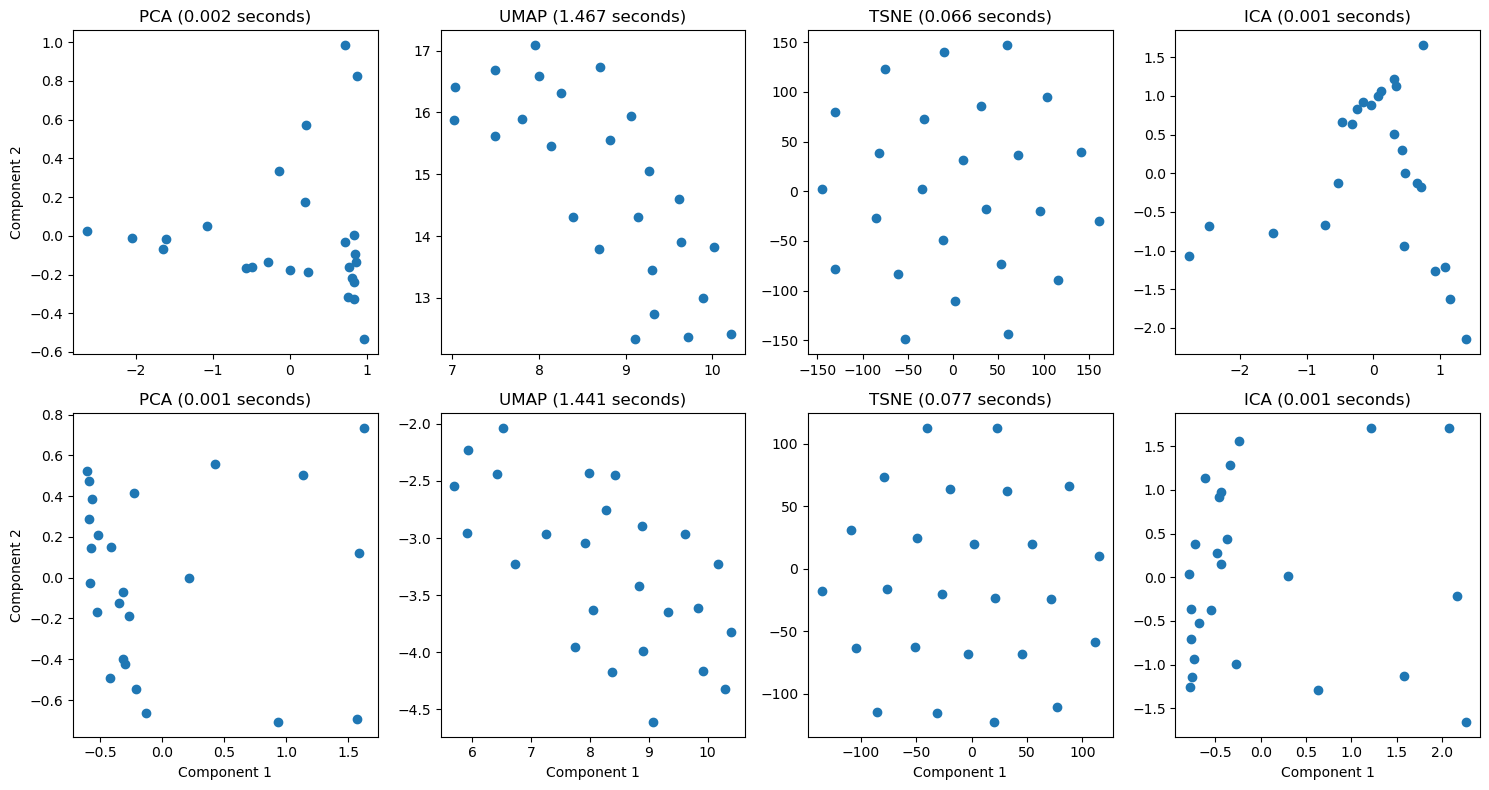

In [215]:
descriptors = [mace_off_features, mace_mp_features]

fig, axes = plt.subplots(2, len(methods), figsize=(15, 8))

for i, descriptors in enumerate(descriptors):
    for j, method in enumerate(methods):
        ax = axes[i, j]
        X_reduced, execution_time = dimensionality_reduction_analysis(
            descriptors, method=method
        )
        ax.scatter(X_reduced[:, 0], X_reduced[:, 1])
        ax.set_title(f"{method} ({execution_time:.3f} seconds)")
        if i == 1:
            ax.set_xlabel("Component 1")
        if j == 0:
            ax.set_ylabel("Component 2")

plt.tight_layout()
plt.show()

#### Dimensionality Reduction on the concatenated features

In [216]:
concatenated_features = np.concatenate((mace_off_features, mace_mp_features), axis=1)

PCA execution time: 0.01 seconds
UMAP execution time: 1.49 seconds
TSNE execution time: 0.09 seconds
ICA execution time: 0.00 seconds


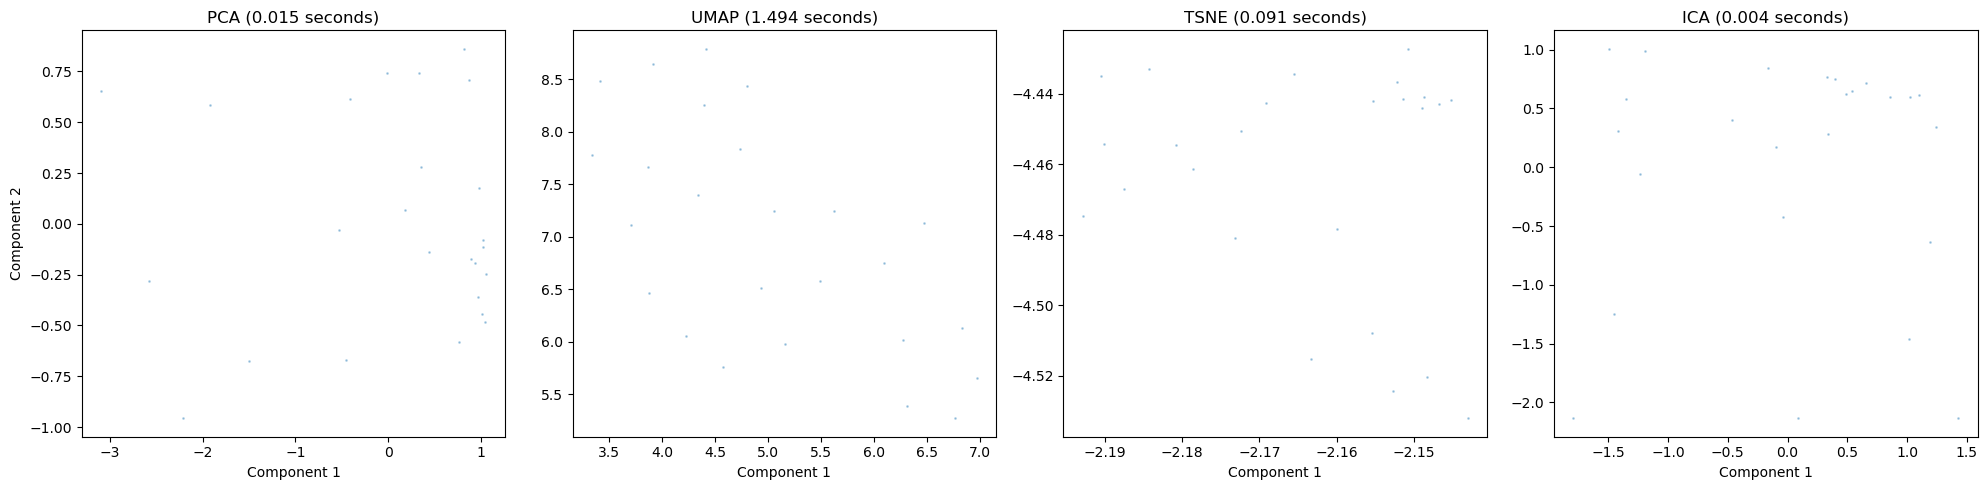

In [217]:
fig, axes = plt.subplots(1, len(methods), figsize=(20, 5))

for j, method in enumerate(methods):
    ax = axes[j]
    X_reduced, execution_time = dimensionality_reduction_analysis(
        concatenated_features, method=method
    )
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.3, s=1)
    ax.set_title(f"{method} ({execution_time:.3f} seconds)")
    ax.set_xlabel("Component 1")
    if j == 0:
        ax.set_ylabel("Component 2")

plt.tight_layout()
plt.show()

### Dimensionality Reduction on whole dataset

Load MACE-OFF and MACE-MP features

In [218]:
mace_mp_features_file = "data/descriptors_MACE_MP0_all.npy"
mace_mp_features = np.load(mace_mp_features_file)

mace_off_features_file = "data/descriptors_MACE_OFF_all.npy"
mace_off_features = np.load(mace_off_features_file)

Loading existing reducer and points for PCA...
Loading existing reducer and points for UMAP...
Loading existing reducer and points for TSNE...
Loading existing reducer and points for ICA...
Loading existing reducer and points for PCA...
Loading existing reducer and points for UMAP...
Loading existing reducer and points for TSNE...
Loading existing reducer and points for ICA...


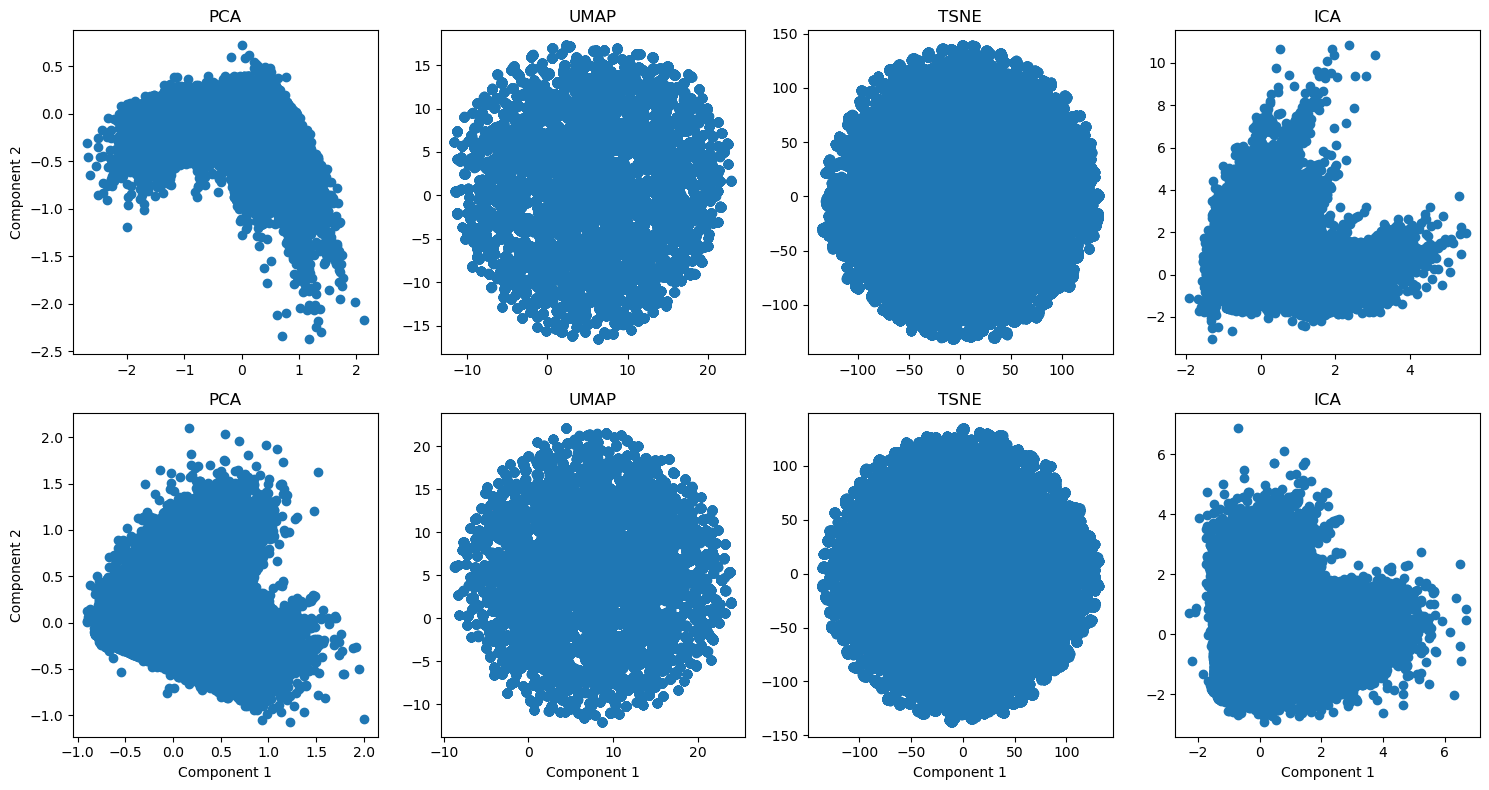

In [219]:
descriptors = [mace_off_features, mace_mp_features]
descriptor_names = ["mace_off", "mace_mp"]

fig, axes = plt.subplots(2, len(methods), figsize=(15, 8))

for i, descriptors in enumerate(descriptors):
    for j, method in enumerate(methods):
        ax = axes[i, j]

        print(f"Loading existing reducer and points for {method}...")
        descriptor = descriptor_names[i]
        reducer_path = os.path.join("data", f"{method}_{descriptor}_reducer.pkl")
        points_path = os.path.join("data", f"{method}_{descriptor}_points.npy")

        reducer = joblib.load(reducer_path)
        X_reduced = np.load(points_path)

        ax.scatter(X_reduced[:, 0], X_reduced[:, 1])
        ax.set_title(method)
        if i == 1:
            ax.set_xlabel("Component 1")
        if j == 0:
            ax.set_ylabel("Component 2")

plt.tight_layout()
plt.show()

### Methods separately

In [220]:
def show_plt(
    data, method_name, features_name, x_label="Component 1", y_label="Component 2"
):
    plt.scatter(data[:, 0], data[:, 1], alpha=0.1, s=1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"{method_name} of {features_name} Features")
    plt.show()

#### PCA

In [221]:
from sklearn.decomposition import PCA


def apply_pca(descriptors):
    return PCA(n_components=2).fit_transform(descriptors)

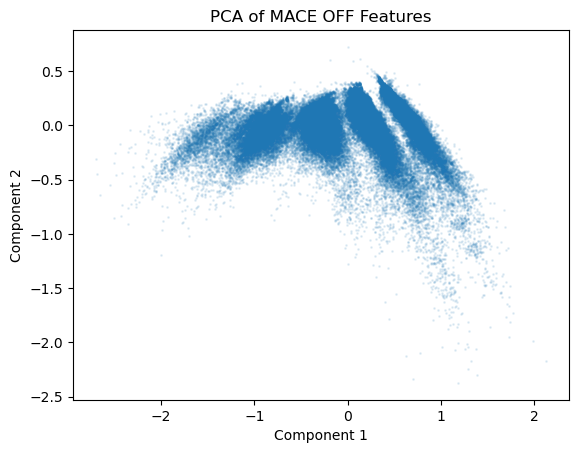

In [222]:
X_pca_mace_off = apply_pca(mace_off_features)

show_plt(X_pca_mace_off, method_name="PCA", features_name="MACE OFF")

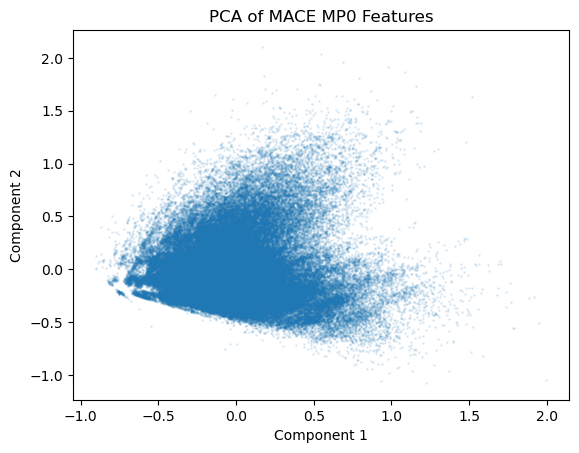

In [223]:
X_pca_mace_mp = apply_pca(mace_mp_features)

show_plt(X_pca_mace_mp, method_name="PCA", features_name="MACE MP0")

#### UMAP

In [224]:
import umap


def apply_umap(descriptors):
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric="euclidean",
        target_metric="categorical",
    )
    return reducer.fit_transform(descriptors)

In [226]:
X_umap_mace_off = apply_umap(mace_off_features)

show_plt(X_umap_mace_off, method_name="UMAP", features_name="MACE OFF")

In [ ]:
X_umap_mace_mp = apply_umap(mace_off_features)

show_plt(X_umap_mace_mp, method_name="UMAP", features_name="MACE MP0")

#### TSNE

In [ ]:
from sklearn.manifold import TSNE


def apply_tsne(descriptors):
    return TSNE(n_components=2).fit_transform(descriptors)

In [ ]:
X_tsne_mace_off = apply_tsne(mace_off_features)

show_plt(X_tsne_mace_off, method_name="TSNE", features_name="MACE OFF")

In [ ]:
X_tsne_mace_mp = apply_tsne(mace_mp_features)

show_plt(X_tsne_mace_mp, method_name="TSNE", features_name="MACE MP0")

#### ICA

In [ ]:
from sklearn.decomposition import FastICA


def apply_ica(descriptors):
    reducer = FastICA(n_components=2)
    return reducer.fit_transform(descriptors)

In [ ]:
X_ica_mace_off = apply_ica(mace_off_features)

show_plt(X_ica_mace_off, method_name="ICA", features_name="MACE OFF")

In [ ]:
X_ica_mace_mp = apply_ica(mace_mp_features)

show_plt(X_ica_mace_mp, method_name="ICA", features_name="MACE MP0")

#### SOAP

In [ ]:
import rascaline
from rascaline.calculators import SoapPowerSpectrum
from metatensor import mean_over_samples


hypers_ps = {
    "cutoff": 5.0,
    "max_radial": 6,
    "max_angular": 6,
    "atomic_gaussian_width": 0.3,
    "center_atom_weight": 0.0,
    "radial_basis": {
        "Gto": {},
    },
    "cutoff_function": {
        "ShiftedCosine": {"width": 0.5},
    },
    "radial_scaling": {"Willatt2018": {"exponent": 7.0, "rate": 1.0, "scale": 2.0}},
}

calculator = SoapPowerSpectrum(**hypers_ps)

In [ ]:
feat = calculator.compute(frames)

feat = feat.keys_to_samples(["center_type"])
feat = feat.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])

feat = mean_over_samples(feat, sample_names=["atom", "center_type"])

Xfeat = feat.block(0).values

KeyboardInterrupt: 

### Chemiscope Visualisation

Extracting all properties

In [ ]:
def extract_properties(frames):
    properties = {prop: [] for prop in frames[0].info.keys()}
    for frame in frames:
        for prop, value in frame.info.items():
            properties[prop].append(value)
    return properties


properties = extract_properties(frames)

In [ ]:
EVERY_N = 25


def display_chemiscope(X_pca, properties, meta):
    return chemiscope.show(
        frames=frames[::EVERY_N],
        properties={
            "PCA 1": {"target": "structure", "values": X_pca[:, 0][::EVERY_N].tolist()},
            "PCA 2": {"target": "structure", "values": X_pca[:, 1][::EVERY_N].tolist()},
            "homo": {"target": "structure", "values": properties["homo"][::EVERY_N]},
            "lumo": {"target": "structure", "values": properties["lumo"][::EVERY_N]},
            "gap": {"target": "structure", "values": properties["gap"][::EVERY_N]},
        },
        meta=meta,
    )

MACE OFF

In [ ]:
display_chemiscope(X_pca_mace_off, properties, meta={"name": "QM9 MACE OFF features"})

MACE MP

In [ ]:
display_chemiscope(X_pca_mace_mp, properties, meta={"name": "QM9 MACE MP features"})